## Open Machine Learning Course 
Author: [Yury Kashnitskiy](https://yorko.github.io) (@yorko). Edited by Sergey Kolchenko (@KolchenkoSergey). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

In [222]:
import os
import json
from tqdm import tqdm_notebook, tqdm
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import Ridge, Lasso
from matplotlib import pyplot as plt
%matplotlib inline

The following code will help to throw away all HTML tags from an article content.

In [181]:
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

Supplementary function to read a JSON line without crashing on escape characters.

In [182]:
def read_json_line(line=None):
    result = None
    try:        
        result = json.loads(line)
    except Exception as e:      
        # Find the offending character index:
        idx_to_replace = int(str(e).split(' ')[-1].replace(')',''))      
        # Remove the offending character:
        new_line = list(line)
        new_line[idx_to_replace] = ' '
        new_line = ''.join(new_line)     
        return read_json_line(line=new_line)
    return result

Extract features `content`, `published`, `title` and `author`, write them to separate files for train and test sets.

In [261]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer
from nltk import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Олег\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Олег\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Олег\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


In [240]:
def extract_features_and_write(path_to_data, inp_filename, is_train=True):
    
    features = ['content', 'published', 'title', 'author', 'desc', 'time_read']
    prefix = 'train' if is_train else 'test'
    feature_files = [open(os.path.join(path_to_data, '{}_{}.txt'.format(prefix, feat)), 'w', encoding='utf-8')
                         for feat in features]
    text_feature_file = open('{}_{}.txt'.format(prefix, 'text_feature'), 'w', encoding='utf-8')
    
    with open(os.path.join(path_to_data, inp_filename), encoding='utf-8') as inp_json_file:
        for line in tqdm_notebook(inp_json_file):
            json_data = read_json_line(line)
            
            #CONTENT
            html = json_data['content'].replace('\n', ' ').replace('\r', ' ')
            content = strip_tags(html)
            images = html.count('<img')
            paragraphs = html.count('</p>')
            links = html.count('<a href=')
            length = len(content)
            text_feature_file.write('{},{},{},{}\n'.format(images, paragraphs, links, length))
            
            #PUBLISHED
            published = json_data['published']['$date']
            
            #TITLE
            title = json_data['title'].replace('\n', ' ').replace('\r', ' ')
            
            #AUTHOR NAME
            author = str(json_data['author']['url'])
            
            #DESCRIPTION
            desc = json_data['meta_tags']['description'].replace('\n', ' ').replace('\r', ' ')
            if (desc == ''):
                desc = 'none'
            #word_tokens = word_tokenize(desc)
            #desc = " ".join([ps.stem(w) for w in word_tokens if not w in stop_words and w.isalpha()])
            
            #TIME TO READ
            time = json_data['meta_tags']['twitter:data1'].replace(' ', '')
            if (time == ''):
                time = '7minread'
            
            feature_files[0].write(content + '\n')
            feature_files[1].write(published + '\n')
            feature_files[2].write(title + '\n')
            feature_files[3].write(author + '\n')  
            feature_files[4].write(desc + '\n')  
            feature_files[5].write(time + '\n')  
    
    for file in feature_files:
        file.close()
    text_feature_file.close()

In [241]:
extract_features_and_write('', 'data/train.json', is_train=True)

In [242]:
extract_features_and_write('', 'data/test.json', is_train=False)

In [268]:
file = open('data/train_author.txt', 'w', encoding='utf-8')
with open(os.path.join('data/train.json'), encoding='utf-8') as inp_json_file:
    for line in tqdm_notebook(inp_json_file):
        json_data = read_json_line(line)
        file.write(json_data['author']['url'].split('@')[1] + '\n')
file.close()
file = open('data/test_author.txt', 'w', encoding='utf-8')
with open(os.path.join('data/test.json'), encoding='utf-8') as inp_json_file:
    for line in tqdm_notebook(inp_json_file):
        json_data = read_json_line(line)
        file.write(json_data['author']['url'].split('@')[1] + '\n')
file.close()

**Add the following groups of features:**
    - Tf-Idf with article content (ngram_range=(1, 2), max_features=100000 but you can try adding more)
    - Tf-Idf with article titles (ngram_range=(1, 2), max_features=100000 but you can try adding more)
    - Time features: publication hour, whether it's morning, day, night, whether it's a weekend
    - Bag of authors (i.e. One-Hot-Encoded author names)

In [258]:
class Tokenizer(object):
    
    def __init__(self, stemmer=PorterStemmer, lemmatizer=WordNetLemmatizer):
        self.stemmer = stemmer()
        self.lemmatizer = lemmatizer()
        
    def __call__(self, doc):
        from string import punctuation, digits
        other_unicode_chars = '’’”“\u200b'
        chars_to_remove = ''.join((punctuation,
                                   digits,
                                   other_unicode_chars))
        transtab = str.maketrans(chars_to_remove, ' '*len(chars_to_remove))
        return [self.stemmer.stem(self.lemmatizer.lemmatize(token, pos='v')) 
                for token in word_tokenize(doc.translate(transtab)) 
                if len(token) >= 3]

In [262]:
from sklearn.feature_extraction import text 
stop_words = text.ENGLISH_STOP_WORDS
temp = []
s = Tokenizer()
for eggs in stop_words:
    token = s(eggs)
    if token:
        temp += token
stop_words = temp

#### Adding titles and content bag-of-words

In [281]:
%%time

tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=50000)
X_train_title_sparse = tfidf.fit_transform(open('train_title.txt', encoding='utf-8'))
print(X_train_title_sparse.shape)
X_test_title_sparse = tfidf.transform(open('test_title.txt', encoding='utf-8'))
print(X_test_title_sparse.shape)

vect = CountVectorizer(max_features=100000)
X_train_content_sparse = vect.fit_transform(open('train_content.txt', encoding='utf-8'))
print(X_train_content_sparse.shape)
X_test_content_sparse = vect.transform(open('test_content.txt', encoding='utf-8'))
print(X_test_content_sparse.shape)


(62313, 50000)
(34645, 50000)
(62313, 100000)
(34645, 100000)
Wall time: 5min 56s


#### Adding desc and time_read

In [265]:
%%time
tfidf = TfidfVectorizer(ngram_range=(1, 2), tokenizer=Tokenizer(),
                                     stop_words=stop_words, max_features=50000)
X_train_desc_sparse = tfidf.fit_transform(open('train_desc.txt', encoding='utf-8'))
print(X_train_desc_sparse.shape)
X_test_desc_sparse = tfidf.transform(open('test_desc.txt', encoding='utf-8'))
print(X_test_desc_sparse.shape)

vect = CountVectorizer(max_features=50000)
X_train_time_read_sparse = vect.fit_transform(open('train_time_read.txt', encoding='utf-8'))
print(X_train_time_read_sparse.shape)
X_test_time_read_sparse = vect.transform(open('test_time_read.txt', encoding='utf-8'))
print(X_test_time_read_sparse.shape)

(62313, 50000)
(34645, 50000)
(62313, 112)
(34645, 112)
Wall time: 2min 47s


#### Authors bag-of-names

In [269]:
%%time

vect = CountVectorizer(max_features=50000)
X_train_author_sparse = vect.fit_transform(open('train_author.txt', encoding='utf-8'))
print(X_train_author_sparse.shape)
X_test_author_sparse = vect.transform(open('test_author.txt', encoding='utf-8'))
print(X_test_author_sparse.shape)

(62313, 32365)
(34645, 32365)
Wall time: 922 ms


### Adding content features like img and len

In [246]:
text_train_df = pd.read_csv('train_text_feature.txt', header=None, names=['images', 'paragraphs', 'links', 'length'])
text_test_df = pd.read_csv('test_text_feature.txt', header=None, names=['images', 'paragraphs', 'links', 'length'])
text_df = pd.concat([text_train_df, text_test_df])
idx_split = text_train_df.shape[0]

In [282]:
scaled_img = StandardScaler().fit_transform(text_df[['images']])
scaled_p = StandardScaler().fit_transform(text_df[['paragraphs']])
scaled_links = StandardScaler().fit_transform(text_df[['links']])
scaled_len = StandardScaler().fit_transform(text_df[['length']])
text_df['short'] = text_df['length'].apply(lambda size: 1 if (size < 1350) else -1)
text_df['medium'] = text_df['length'].apply(lambda size: 1 if (size >= 1350 and size < 2700) else -1)
text_df['long'] = text_df['length'].apply(lambda size: 1 if (size >= 2700 and size < 6750) else -1)
text_df['huge'] = text_df['length'].apply(lambda size: 1 if (size >= 6750) else -1)


X_text_features = np.hstack([scaled_img, 
                             scaled_p,
                             scaled_links, 
                             #scaled_len,
                             text_df['short'].values.reshape(-1, 1),
                             text_df['medium'].values.reshape(-1, 1),
                             text_df['long'].values.reshape(-1, 1),
                             text_df['huge'].values.reshape(-1, 1)
                            ])
X_train_text_features = X_text_features[:idx_split, :]
X_test_text_features = X_text_features[idx_split:, :]

#### Adding time features

In [212]:
import dateutil.parser
time_train_df = pd.read_csv('train_published.txt', header=None, names=['published'])
time_test_df = pd.read_csv('test_published.txt', header=None, names=['published'])
time_df = pd.concat([time_train_df, time_test_df])
idx_split = time_train_df.shape[0]

time_df['published'] = time_df['published'].apply(lambda s: dateutil.parser.parse(s))
time_df.head()

,published
0,2012-08-13 22:54:53.510000+00:00
1,2015-08-03 07:44:50.331000+00:00
2,2017-02-05 13:08:17.410000+00:00
3,2017-05-06 08:16:30.776000+00:00
4,2017-06-04 14:46:25.772000+00:00


In [214]:
%%time
time_df['year'] = time_df['published'].apply(lambda ts: ts.year)
scaled_year = StandardScaler().fit_transform(time_df[['year']])
time_df['month'] = time_df['published'].apply(lambda ts: ts.month)

weekdays = ['day%s' % i for i in range(1, 8)]
hours = ['hour%s' % i for i in range(0, 24)]

for i, day in enumerate(weekdays):
    time_df[day] = time_df['published'].apply(lambda ts: 1 if (ts.weekday() == i) else -1)
for i, hour in tqdm_notebook(enumerate(hours)):
    time_df[hour] = time_df['published'].apply(lambda ts: 1 if (ts.hour == i) else -1)
    
time_df['isweekend'] = time_df['published'].apply(lambda ts: 1 if (ts.weekday() >= 6) else -1)
time_df['winter'] = time_df['month'].apply(lambda month: 1 if (month <= 2 or month == 12) else -1)
time_df['spring'] = time_df['month'].apply(lambda month: 1 if (month >= 3 and month <= 5) else -1)
time_df['summer'] = time_df['month'].apply(lambda month: 1 if (month >= 6 and month <= 8) else -1)
time_df['autumn'] = time_df['month'].apply(lambda month: 1 if (month >= 9 and month <= 11) else -1)


Wall time: 19.3 s


In [227]:
X_time_features = np.hstack([#scaled_year,
                          time_df[hours].values.reshape(-1, 24),
                          time_df['winter'].values.reshape(-1, 1),
                          time_df['spring'].values.reshape(-1, 1),
                          time_df['summer'].values.reshape(-1, 1),
                          time_df['autumn'].values.reshape(-1, 1),
                          time_df['isweekend'].values.reshape(-1, 1),
                         ])
X_train_time_features = X_time_features[:idx_split, :]
X_test_time_features = X_time_features[idx_split:, :]

**Join all sparse matrices.**

In [283]:
X_train_sparse = hstack([X_train_content_sparse, X_train_title_sparse,
                         X_train_author_sparse, 
                         X_train_time_features,
                         X_train_desc_sparse,
                         X_train_time_read_sparse,
                         X_train_text_features,
                        ]).tocsr()

In [284]:
X_test_sparse = hstack([X_test_content_sparse, X_test_title_sparse,
                        X_test_author_sparse, 
                        X_test_time_features,
                        X_test_desc_sparse,
                        X_test_time_read_sparse,
                        X_test_text_features
                       ]).tocsr()

In [285]:
X_train_sparse.shape, X_test_sparse.shape

((62313, 232513), (34645, 232513))

**Read train target and split data for validation.**

In [77]:
train_target = pd.read_csv(os.path.join('', 'data/train_log1p_recommends.csv'), index_col='id')
y_train = train_target['log_recommends'].values

In [273]:
train_part_size = int(0.7 * train_target.shape[0])
X_train_part_sparse = X_train_sparse[:train_part_size, :]
y_train_part = y_train[:train_part_size]
X_valid_sparse =  X_train_sparse[train_part_size:, :]
y_valid = y_train[train_part_size:]

**Train a simple Ridge model and check MAE on the validation set.**

In [286]:
%%time
ridge = Ridge(random_state=17, alpha=0.5)
ridge.fit(X_train_part_sparse, (y_train_part))

Wall time: 172 ms


In [290]:
%%time
ridge_pred = (ridge.predict(X_valid_sparse))
ridge_valid_mae = mean_absolute_error((y_valid), ridge_pred)
print(ridge_valid_mae)

1.4464968989567717
Wall time: 3.25 s


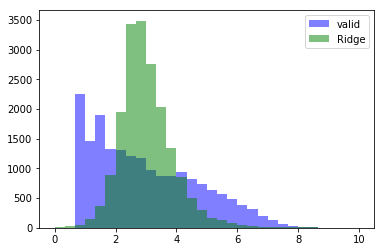

In [279]:
#plt.hist(np.log1p(y_train_part), bins=30, alpha=.5, color='red', label='train', range=(0,10))
plt.hist((y_valid), bins=30, alpha=.5, color='blue', label='valid', range=(0,10))
plt.hist((ridge_pred), bins=30, alpha=.5, color='green', label='Ridge', range=(0,10))
plt.legend()

**Train the same Ridge with all available data, make predictions for the test set and form a submission file.**

In [287]:
ridge.fit(X_train_sparse, (y_train))
ridge_test_pred = (ridge.predict(X_test_sparse))

In [288]:
def write_submission_file(prediction, filename, path_to_sample='sample_submission.csv'):
    submission = pd.read_csv(path_to_sample, index_col='id')
    submission['log_recommends'] = prediction
    submission.to_csv(filename)

In [289]:
mean_test_target = 4.33328
write_submission_file(ridge_test_pred + mean_test_target - y_train.mean(), 'medium_submission_!!!.csv')

Some ideas for improvement:

- Engineer good features, this is the key to success. Some simple features will be based on publication time, authors, content length and so on
- You may not ignore HTML and extract some features from there
- You'd better experiment with your validation scheme. You should see a correlation between your local improvements and LB score
- Try TF-IDF, ngrams, Word2Vec and GloVe embeddings
- Try various NLP techniques like stemming and lemmatization
- Tune hyperparameters. In our example, we've left only 50k features and used C=1 as a regularization parameter, this can be changed
- SGD and Vowpal Wabbit will learn much faster
- Play around with blending and/or stacking. An intro is given in [this Kernel](https://www.kaggle.com/kashnitsky/ridge-and-lightgbm-simple-blending) by @yorko 
- In our course, we don't cover neural nets. But it's not obliged to use GRUs/LSTMs/whatever in this competition.

Good luck!

